# Proposed Unsupervised Contextual Anomaly Detection Model on CleanedLog
---
[link to paper](https://www.skopik.at/ait/2018_ispec.pdf)

1. Parse log file, text preprocessing
2. Feature Engineering with word embedding model (ex. Word2Vec, BERT, Universal Sentence Encoder etc.)
3. Cluster log lines into k groups (K-Means etc.)
4. Determine cluster counts occurring within fixed time windows, t
5. Compute moving averages of cluster counts (or more robust models such as LSTM)
6. Forecast one-timestep ahead
7. Compute confidence interval for forecast and classify anomalies based on this interval

### Install requirnments 
```bash
$ pip install numpy pandas nltk gensim tqdm
$ pip install scipy scikit-learn keras
```

In [1]:
import pandas as pd
import numpy as np

In [163]:
df = pd.read_csv("CleanedLog.csv")   #csv file with random time added

In [164]:
df

,Unnamed: 0,LineId,host,timestamp,service,thread_id,message_id,structured_data,log_level,log_message,EventId,EventTemplate,ParameterList
0,0,1,NaN,35:16.1,CORE,{main},-|-,[{}],INFO,Found Public API candidate:C:/Program Files/De...,61c07f7d,found public api,<bound method Parser.get_parameter_list of <dr...
1,1,2,NaN,35:16.2,CORE,{main},-|-,[{}],INFO,Public API to load:C:\Program Files\DellCamero...,3a100ee9,public api,<bound method Parser.get_parameter_list of <dr...
2,2,3,NaN,35:16.2,CORE,{main},-|-,[{}],INFO,Root WebApplicationContext: initialization sta...,1ad8b3a2,root web application context initialization st...,<bound method Parser.get_parameter_list of <dr...
3,3,4,NaN,35:16.4,CORE,{main},-|-,[{}],INFO,Refreshing Root WebApplicationContext: startup...,28410e9c,refreshing root web application context startu...,<bound method Parser.get_parameter_list of <dr...
4,4,5,NaN,35:16.5,CORE,{main},-|-,[{}],INFO,Loading XML bean definitions from ServletConte...,a27de3e5,loading xml bean definition from servlet conte...,<bound method Parser.get_parameter_list of <dr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102461,102461,102462,NaN,39:31.4,CORE,{wff-thread-116},none|none,"[{{Correlation-Id,d93c5a57-f236-4dbf-8139-c0e3...",INFO,[filterPolicySettingsByUserDevice] Called poli...,df7da411,filter policy setting by user device called po...,<bound method Parser.get_parameter_list of <dr...
102462,102462,102463,NaN,39:31.4,CORE,{wff-thread-116},none|core,"[{{Correlation-Id,d93c5a57-f236-4dbf-8139-c0e3...",INFO,getKeyInfo OK for endpointUUID: 1A630808-E811-...,773e2657,get key info ok for endpoint uuid,<bound method Parser.get_parameter_list of <dr...
102463,102463,102464,NaN,39:31.4,CORE,{wff-thread-116},none|none,"[{{Correlation-Id,d93c5a57-f236-4dbf-8139-c0e3...",INFO,Time to complete request in milliseconds: 28,d8df4591,time to complete request in millisecond,<bound method Parser.get_parameter_list of <dr...
102464,102464,102465,NaN,39:31.4,CORE,{gif-notify,thread-18},"none|none [{{Correlation-Id,d93c5a57-f236-4dbf...",INFO,returning HTTP response code 200,509a5b6e,returning http response code,<bound method Parser.get_parameter_list of <dr...


In [165]:
df['service'] = pd.factorize(df['service'])[0] + 1
df['thread_id'] = pd.factorize(df['thread_id'])[0] + 1
df['message_id'] = pd.factorize(df['message_id'])[0] + 1
df['structured_data'] = pd.factorize(df['structured_data'])[0] + 1
df['log_level'] = pd.factorize(df['log_level'])[0] + 1
df['log_message'] = pd.factorize(df['log_message'])[0] + 1
df['EventId'] = pd.factorize(df['EventId'])[0] + 1
df['ParameterList'] = pd.factorize(df['ParameterList'])[0] + 1



df

,Unnamed: 0,LineId,host,timestamp,service,thread_id,message_id,structured_data,log_level,log_message,EventId,EventTemplate,ParameterList
0,0,1,NaN,35:16.1,1,1,1,1,1,1,1,found public api,1
1,1,2,NaN,35:16.2,1,1,1,1,1,2,2,public api,2
2,2,3,NaN,35:16.2,1,1,1,1,1,3,3,root web application context initialization st...,3
3,3,4,NaN,35:16.4,1,1,1,1,1,4,4,refreshing root web application context startu...,4
4,4,5,NaN,35:16.5,1,1,1,1,1,5,5,loading xml bean definition from servlet conte...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102461,102461,102462,NaN,39:31.4,1,216,2,8766,1,2012,331,filter policy setting by user device called po...,85
102462,102462,102463,NaN,39:31.4,1,216,4,8766,1,13387,332,get key info ok for endpoint uuid,86
102463,102463,102464,NaN,39:31.4,1,216,2,8766,1,2114,268,time to complete request in millisecond,143
102464,102464,102465,NaN,39:31.4,1,24,41,8767,1,1672,269,returning http response code,86


In [166]:
from datetime import datetime, timedelta
h = 0
last_m =0
def add_hour(x):
    global h,last_m
    
    dt = datetime.strptime(x, "%M:%S.%f")

    if last_m == 59 and dt.minute != 59:
        h+=1
        dt = dt + timedelta(hours=h)
        last_m = dt.minute
        return dt.strftime('%H:%M:%S')
    else:
        last_m = dt.minute
        dt = dt + timedelta(hours=h)
        return dt.strftime('%H:%M:%S')
        
df['new_time'] = df['timestamp'].apply(lambda x:add_hour(x))

In [167]:
df

,Unnamed: 0,LineId,host,timestamp,service,thread_id,message_id,structured_data,log_level,log_message,EventId,EventTemplate,ParameterList,new_time
0,0,1,NaN,35:16.1,1,1,1,1,1,1,1,found public api,1,00:35:16
1,1,2,NaN,35:16.2,1,1,1,1,1,2,2,public api,2,00:35:16
2,2,3,NaN,35:16.2,1,1,1,1,1,3,3,root web application context initialization st...,3,00:35:16
3,3,4,NaN,35:16.4,1,1,1,1,1,4,4,refreshing root web application context startu...,4,00:35:16
4,4,5,NaN,35:16.5,1,1,1,1,1,5,5,loading xml bean definition from servlet conte...,5,00:35:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102461,102461,102462,NaN,39:31.4,1,216,2,8766,1,2012,331,filter policy setting by user device called po...,85,02:39:31
102462,102462,102463,NaN,39:31.4,1,216,4,8766,1,13387,332,get key info ok for endpoint uuid,86,02:39:31
102463,102463,102464,NaN,39:31.4,1,216,2,8766,1,2114,268,time to complete request in millisecond,143,02:39:31
102464,102464,102465,NaN,39:31.4,1,24,41,8767,1,1672,269,returning http response code,86,02:39:31


In [83]:
df.describe()

,Unnamed: 0,LineId,host,service,thread_id,message_id,structured_data,log_level,log_message,EventId,ParameterList
count,102466.000000,102466.000000,0.0,102466.0,102466.000000,102466.000000,102466.000000,102466.000000,102466.000000,102466.000000,102466.000000
mean,51232.500000,51233.500000,NaN,1.0,184.464427,5.789589,2871.181690,1.011301,5032.014541,345.417514,82.255236
std,29579.530679,29579.530679,NaN,0.0,132.823982,20.752232,2826.180671,0.131614,2240.594908,50.840195,278.334007
min,0.000000,1.000000,NaN,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,25616.250000,25617.250000,NaN,1.0,87.000000,2.000000,1136.000000,1.000000,3954.000000,361.000000,3.000000
50%,51232.500000,51233.500000,NaN,1.0,142.000000,2.000000,1136.000000,1.000000,4471.000000,361.000000,3.000000
75%,76848.750000,76849.750000,NaN,1.0,266.000000,2.000000,5790.000000,1.000000,6283.000000,372.000000,3.000000
max,102465.000000,102466.000000,NaN,1.0,545.000000,179.000000,8768.000000,5.000000,13388.000000,481.000000,2445.000000


**Make the text file for word tokenization**

In [6]:
import os 
name_of_text_file = 'input_2.txt'

if name_of_text_file not in os.listdir(os.getcwd()):
    
    filedata = ' ' + df['EventTemplate'] +' '

    s = [x for x in filedata]
    text = ''.join(s)

    text_file = open(name_of_text_file, "w")      
    text_file.write(text)
    text_file.close()

## Word2Vec Modeling 

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from tqdm import tqdm

In [8]:
sample = open(name_of_text_file, "r") 
s = sample.read() 

f = s.replace("\n", " ")
symbols = ['/', '<', '>', ':', '.', ':', '*']          # to filter out the symbols 
data = [] 

for i in tqdm(sent_tokenize(f)): 
    temp = [] 
    for j in word_tokenize(i):
        if j not in symbols:
            temp.append(j.lower()) 

    data.append(temp) 

# Create CBOW model 
model1 = gensim.models.Word2Vec(data, min_count = 1, size = 32, window = 5) 

100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


In [9]:
model1.most_similar('you'.lower())

<ipython-input-9-d8e8a1207f57>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model1.most_similar('you'.lower())


[('ugku', 0.9726849794387817),
 ('good', 0.9725306630134583),
 ('utapkaa', 0.9723988771438599),
 ('throw', 0.9717992544174194),
 ('afsmr', 0.9714429974555969),
 ('nv', 0.971121072769165),
 ('databind', 0.971019983291626),
 ('trusted', 0.9709981083869934),
 ('consumer', 0.9709060192108154),
 ('yr', 0.9708030223846436)]

In [10]:
print(model1.similarity('public', 'key')) 

0.99956626


<ipython-input-10-2780ba7dd59d>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  print(model1.similarity('public', 'key'))


#### Make sentence vec

In [11]:
sen = df['EventTemplate'] 

In [12]:
sen2vec = []
for x in tqdm(sen):
    for i in sent_tokenize(x): 
        temp = [] 
        for j in word_tokenize(i):
            if j not in symbols:
                try:
                    temp.append(model1[j.lower()])
                except:
                    print(j)
    l = np.array(temp)
    l = np.average(l,axis=0)
    sen2vec.append(l)

  0%|          | 0/102466 [00:00<?, ?it/s]<ipython-input-12-967a293b9c4e>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  temp.append(model1[j.lower()])
100%|██████████| 102466/102466 [00:21<00:00, 4697.56it/s]


In [13]:
sen2vec = np.array(sen2vec)

In [14]:
sen2vec.shape

(102466, 32)

#### window generator

In [57]:
from datetime import datetime, timedelta
class DataGen:
    def __init__(self, time, window, pattern="%M:%S.%f"):
        self.pattern = pattern
        self.time = time
        self.window = timedelta(minutes=window)
        self.index = 0
        self.start = datetime.strptime(self.time[0], self.pattern) 
        self.it = 1

    def __iter__(self):
        return self

    def __next__(self): 
        self.indextime = datetime.strptime(self.time[self.index], self.pattern)
        for x in range(self.index, len(self.time)):
            temp =  datetime.strptime(self.time[x], self.pattern) 
            if temp - self.start >= self.window*self.it:
                self.index = x
                self.it+=1
                return self.index
        raise StopIteration
        
        
def extract_max_min(dic):
    max_value = -1
    min_value = 100000000
    for x in dic:
        if dic[x] > max_value:
            max_value = dic[x]
        if dic[x] < min_value:
            min_value = dic[x]
    return max_value, min_value
        

In [103]:
for x in DataGen(df["new_time"], window=2, pattern="%H:%M:%S"):
    print(x)
    print(df["new_time"][x])

351
00:37:27
1989
00:39:16
2887
00:41:16
3853
00:43:16
4553
00:45:16
5529
00:47:16
5997
00:49:17
13017
00:51:20
13342
00:53:18
13563
00:55:16
13850
00:57:16
14281
00:59:16
14545
01:01:19
14865
01:03:20
21627
01:05:16
21835
01:07:17
22182
01:09:16
22554
01:11:18
22749
01:13:16
29621
01:15:17
29810
01:17:16
30086
01:19:17
30349
01:21:16
30783
01:23:16
31002
01:25:16
31276
01:27:16
31513
01:29:16
31846
01:31:16
32007
01:33:19
32218
01:35:16
32584
01:37:18
32871
01:39:17
39785
01:41:20
40056
01:43:16
47001
01:45:16
47314
01:47:16
47590
01:49:16
54475
01:51:16
54782
01:53:18
55059
01:55:18
55429
01:57:16
55833
01:59:17
62740
02:01:18
62992
02:03:18
63268
02:05:16
63752
02:07:16
64032
02:09:16
64383
02:11:16
65003
02:13:16
71891
02:15:17
72097
02:17:16
72359
02:19:17
72626
02:21:18
72908
02:23:17
79827
02:25:17
80101
02:27:17
80385
02:29:16
94097
02:31:17
94677
02:33:17
101463
02:35:16
102115
02:37:16
102412
02:39:20


In [32]:
sen2vec[0:351].shape

(351, 32)

In [33]:
df['timestamp'][351]

'37:27.2'

#### Saving all columns to time window relations

In [109]:
itr = 0
dic_col_relation = {}
start = 0
for x in DataGen(df["new_time"], window=0.5,pattern="%H:%M:%S"):
    
    dic_col_relation[itr] = {'start':start, 'end':x}
    start = x
    itr+=1

In [110]:
dic_col_relation

{0: {'start': 0, 'end': 159},
 1: {'start': 159, 'end': 201},
 2: {'start': 201, 'end': 206},
 3: {'start': 206, 'end': 228},
 4: {'start': 228, 'end': 327},
 5: {'start': 327, 'end': 337},
 6: {'start': 337, 'end': 342},
 7: {'start': 342, 'end': 351},
 8: {'start': 351, 'end': 356},
 9: {'start': 356, 'end': 387},
 10: {'start': 387, 'end': 506},
 11: {'start': 506, 'end': 624},
 12: {'start': 624, 'end': 711},
 13: {'start': 711, 'end': 721},
 14: {'start': 721, 'end': 1128},
 15: {'start': 1128, 'end': 1989},
 16: {'start': 1989, 'end': 2255},
 17: {'start': 2255, 'end': 2322},
 18: {'start': 2322, 'end': 2347},
 19: {'start': 2347, 'end': 2361},
 20: {'start': 2361, 'end': 2522},
 21: {'start': 2522, 'end': 2635},
 22: {'start': 2635, 'end': 2743},
 23: {'start': 2743, 'end': 2887},
 24: {'start': 2887, 'end': 3056},
 25: {'start': 3056, 'end': 3249},
 26: {'start': 3249, 'end': 3345},
 27: {'start': 3345, 'end': 3461},
 28: {'start': 3461, 'end': 3578},
 29: {'start': 3578, 'end'

## Step 3 - Auto K mean algo

In [111]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [112]:
plt.style.use('ggplot')

In [122]:
training_file_name = 'k_values_CleanedLog.npy'

if training_file_name not in os.listdir(os.getcwd()):
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    print('getting k values...')

    k_values = []
    cluster_values = []

    start = 0
    for end in tqdm(DataGen(df["new_time"], window=0.5,pattern="%H:%M:%S")):

        X = sen2vec[start:end]
        start, end = end, _

        k_values_score = []
        clusters = []
        for n_clusters in range_n_clusters:

            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)
            unique, counts = np.unique(cluster_labels, return_counts=True)
            stats = dict(zip(unique, counts))
            max_value, min_value = extract_max_min(stats)
            clusters.append([max_value, min_value])
            silhouette_avg = silhouette_score(X, cluster_labels)
            k_values_score.append(silhouette_avg)    
        
    #     print(k_values_score)
        i = np.argmax(k_values_score)
        k_value = range_n_clusters[i]
        max_value, min_value = clusters[i]
        cluster_values.append([max_value, min_value])
        k_values.append(k_value)

0it [00:00, ?it/s]

getting k values...


3it [00:01,  2.11it/s]/home/vaibhav/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/vaibhav/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
9it [00:13,  2.23s/it]/home/vaibhav/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/vaibhav/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_cl

224it [04:25,  1.91s/it]/home/vaibhav/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/vaibhav/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
248it [05:40,  1.37s/it]


https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [123]:
# np.save('k_values_CleanedLog.npy', k_values)          # save the result of training in k_values.npy file 

In [124]:
# np.save('cluster_values_CleanedLog.npy', cluster_values)

In [125]:
k_values = np.load('k_values_CleanedLog.npy')        # load the result of training from k_values.npy file
cluster_values = np.load('cluster_values_CleanedLog.npy')   

Text(0, 0.5, 'k-number')

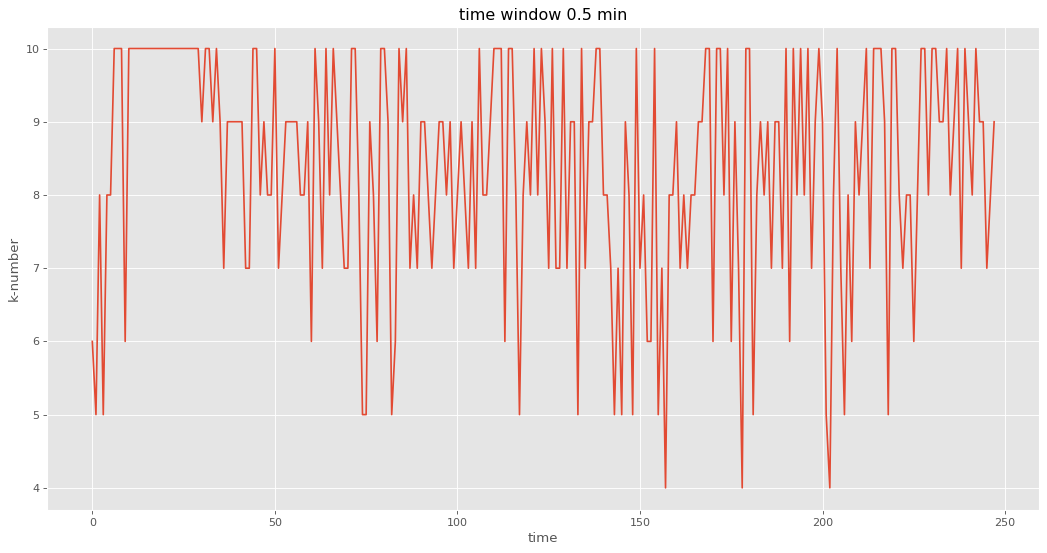

In [129]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(k_values, '-')
plt.title("time window 0.5 min")
plt.xlabel("time")
plt.ylabel("k-number")

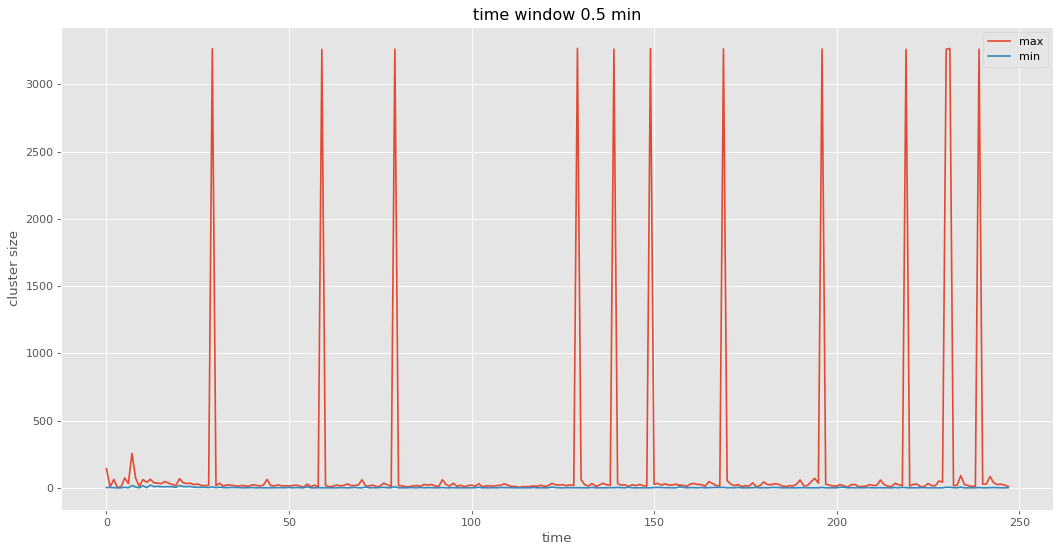

In [128]:
fig = figure(num=None, figsize=(16, 8), dpi=80)
plt.plot(cluster_values[:,0], '-', label='max')
plt.plot(cluster_values[:,1], '-', label='min')

plt.title("time window 0.5 min")
plt.xlabel("time")
plt.ylabel("cluster size")
plt.savefig("min_max_cluster_size")
plt.legend()

## Model 

In [130]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.layers import LSTM
from keras import regularizers
from keras import optimizers
from math import sqrt

from keras.models import Model, load_model

<ipython-input-130-8e8fffb7cf54>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [131]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)

    return df
# create a differenced series


def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
# invert differenced value


def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
# scale train and test data to [-1, 1]


def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value


def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
# fit an LSTM network to training data


def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model
# make a one-step forecast


def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#### LSTM model training 

In [143]:
data = (cluster_values[:,0] + cluster_values[:,1])/2
supervised = timeseries_to_supervised(data, 1)
supervised_values = supervised.values

test_size = 30

train_lstm, test_lstm = supervised_values[0:-test_size], supervised_values[-test_size:]
# transform the scale of the data
scaler, train_scaled_lstm, test_scaled_lstm = scale(train_lstm, test_lstm)

# fit the model                 batch,Epoch,Neurons
lstm_model = fit_lstm(train_scaled_lstm, 1, 50 , 32)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled_lstm[:, 0].reshape(len(train_scaled_lstm), 1, 1)
#lstm_model.predict(train_reshaped, batch_size=1)

218/218 [==============================] - 0s 1ms/step - loss: 0.1408


In [144]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.patches import Ellipse


predictions = list()
predictions_std_test = list()

for i in tqdm(range(0,len(test_scaled_lstm))):
#make one-step forecast
    X, y = test_scaled_lstm[i, 0:-1], test_scaled_lstm[i, -1]
    
    stats = []
    for x in range(10):
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        stats.append(yhat)
    stats = np.array(stats)
    yhat = stats.mean()
    yhat_std = stats.std()
    
    # store forecast
    predictions.append(yhat)
    predictions_std_test.append(yhat_std)
    expected = k_values[len(train_lstm) + i ]
    

100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


In [145]:
threshold = 3*np.median(predictions_std_test)
anomly_location = []
for x in range(len(predictions_std_test)):
    if predictions_std_test[x] > threshold:
        print(x)
        anomly_location.append(x)

0
2
3
4
13
14
15
16
22
23
24


## graphs

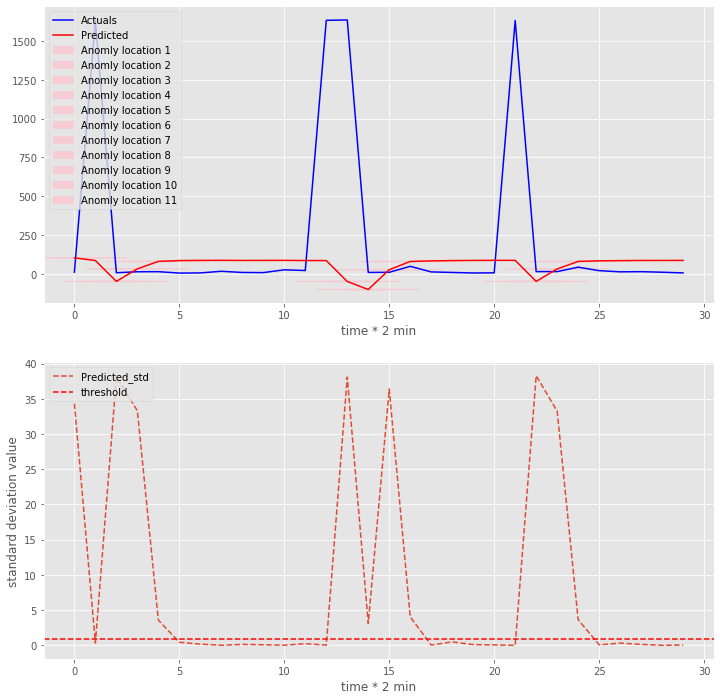

In [146]:
# line plot of observed vs predicted
figsize=(12, 12)
fig, axs = plt.subplots(2,figsize=figsize)


axs[0].plot(data[-test_size:],color='blue',label='Actuals')
axs[0].plot(predictions,'r-',label='Predicted')

anomly_index=0
for loc in anomly_location:
    anomly_index+=1
    circle = Ellipse((loc, predictions[loc]), width=5, height=7.5 , color='pink',alpha=0.7, fill=True, label=f'Anomly location {anomly_index}')
    axs[0].add_patch(circle)

axs[1].plot(predictions_std_test,'--',label='Predicted_std')
y = threshold
axs[1].axhline(y=y, color='r', linestyle='--',label='threshold')


axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')

# axs[0].set_ylim([1,12])
axs[0].set_xlabel('time * 2 min')
axs[1].set_xlabel('time * 2 min')
axs[1].set_ylabel('standard deviation value')


axs[1].grid(True)
plt.savefig('Anomly_loc.png')
plt.show()

In [147]:
predicted_df=pd.DataFrame()
predicted_df['actuals']=data[-test_size:]
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)

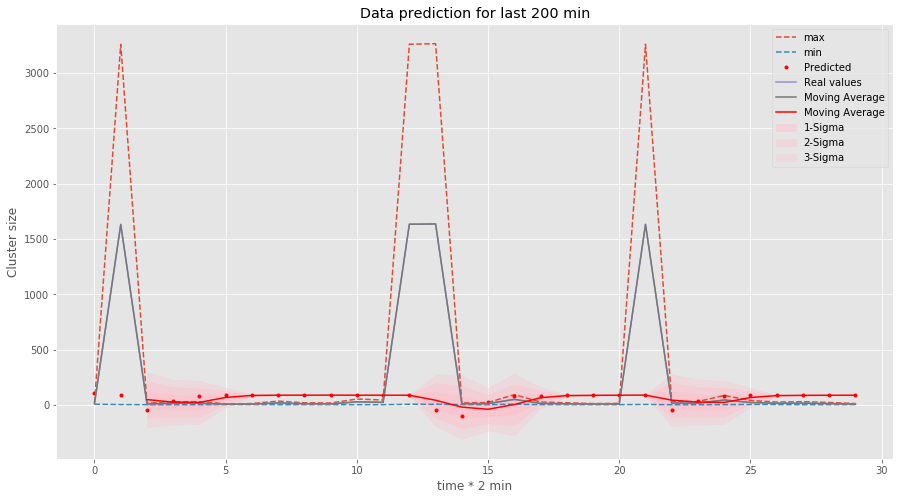

In [149]:
df = predicted_df['predicted']

fig, ax1 = plt.subplots(1, 1,figsize=(15, 8))
ax1.plot(cluster_values[-30:,0],'--', label='max')
ax1.plot(cluster_values[-30:,1],'--', label='min')

ax1.plot(list(df.index), df.iloc[:],'r.',label='Predicted')
ax1.plot(list(df.index), predicted_df['actuals'],label='Real values')
ax1.plot(list(df.index), predicted_df['actuals'],label='Moving Average')
ax1.plot(list(df.index), df.rolling(window=3).mean(),'r',label='Moving Average')

mu = df.rolling(window=3).mean()
sigma = df.rolling(window=3).std()
one_sigma_pos = mu+sigma
one_sigma_neg = mu-sigma
two_sigma_pos = mu+2*sigma
two_sigma_neg = mu-2*sigma
three_sigma_pos = mu+3*sigma
three_sigma_neg = mu-3*sigma

ax1.fill_between(df.index, one_sigma_pos, one_sigma_neg ,color='pink',alpha=0.5,label='1-Sigma')
ax1.fill_between(df.index, two_sigma_pos, two_sigma_neg ,color='pink',alpha=0.4,label='2-Sigma')
ax1.fill_between(df.index, three_sigma_pos, three_sigma_neg ,color='pink',alpha=0.3,label='3-Sigma')


ax1.set_xlabel('time * 2 min')
ax1.set_ylabel('Cluster size')
ax1.set_title('Data prediction for last 200 min')

ax1.legend();
plt.savefig('mu-sigma.png')
plt.show()

https://datascience.stackexchange.com/questions/42715/how-to-calculate-prediction-error-in-a-lstm-keras

https://medium.com/hal24k-techblog/how-to-generate-neural-network-confidence-intervals-with-keras-e4c0b78ebbdf

## Step-6, Getting anomly location and saving it back to csv file 
---
- 1 is its anomalous
- 0 if its not

### prediction on full data

In [150]:
predictions = list()
predictions_std = list()

for i in tqdm(range(0,len(train_scaled_lstm))):
#make one-step forecast
    X, y = train_scaled_lstm[i, 0:-1], train_scaled_lstm[i, -1]
    
    stats = []
    for x in range(10):
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        stats.append(yhat)
    stats = np.array(stats)
    yhat = stats.mean()
    yhat_std = stats.std()
    
    # store forecast
    predictions.append(yhat)
    predictions_std.append(yhat_std)

100%|██████████| 218/218 [00:59<00:00,  3.67it/s]


In [151]:
final_anomly_location = []
for x in range(len(predictions_std)):
    if predictions_std[x] > threshold:
        print(x)
        final_anomly_location.append(x)

1
8
9
30
31
32
60
61
62
80
81
82
130
131
132
140
141
142
150
151
152
170
171
172
197
198
199


In [152]:
anomly_location_in_test = [x+len(train_scaled_lstm) for x in anomly_location]

final_anomly_location.extend(anomly_location_in_test)

In [153]:
final_anomly_location

[1,
 8,
 9,
 30,
 31,
 32,
 60,
 61,
 62,
 80,
 81,
 82,
 130,
 131,
 132,
 140,
 141,
 142,
 150,
 151,
 152,
 170,
 171,
 172,
 197,
 198,
 199,
 218,
 220,
 221,
 222,
 231,
 232,
 233,
 234,
 240,
 241,
 242]

In [154]:
anomly_list = np.array([0]*(len(train_scaled_lstm)+len(test_scaled_lstm)))

In [155]:
anomly_list[final_anomly_location]=1

### Plot

In [156]:
predictions_std.extend(predictions_std_test)

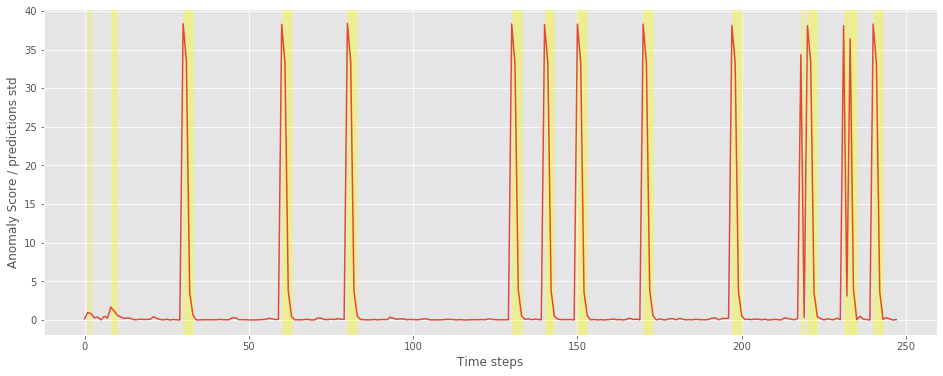

In [157]:
plt.figure(figsize=(16,6))
plt.plot(predictions_std)
for i in final_anomly_location:
    plt.axvspan(i,i+1, alpha=0.3, color='yellow')
plt.xlabel('Time steps')
plt.ylabel('Anomaly Score / predictions std')
plt.savefig('aggregated anomaly score.png')
plt.show()

In [158]:
anomly_list

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0])

#### Final suspected columns

In [159]:
suspected_columns = []
for x in range(len(anomly_list)):
    if anomly_list[x] == 1:
        print(dic_col_relation[x])
        r = list(range(dic_col_relation[x]['start'], dic_col_relation[x]['end']))
        suspected_columns.extend(r)

{'start': 159, 'end': 201}
{'start': 351, 'end': 356}
{'start': 356, 'end': 387}
{'start': 3661, 'end': 3734}
{'start': 3734, 'end': 3853}
{'start': 3853, 'end': 3962}
{'start': 12791, 'end': 12833}
{'start': 12833, 'end': 12859}
{'start': 12859, 'end': 12960}
{'start': 13563, 'end': 13625}
{'start': 13625, 'end': 13653}
{'start': 13653, 'end': 13694}
{'start': 21904, 'end': 21942}
{'start': 21942, 'end': 21966}
{'start': 21966, 'end': 22052}
{'start': 22337, 'end': 22442}
{'start': 22442, 'end': 22459}
{'start': 22459, 'end': 22520}
{'start': 22710, 'end': 22732}
{'start': 22732, 'end': 22749}
{'start': 22749, 'end': 22838}
{'start': 29880, 'end': 29914}
{'start': 29914, 'end': 29937}
{'start': 29937, 'end': 29972}
{'start': 30938, 'end': 30950}
{'start': 30950, 'end': 30975}
{'start': 30975, 'end': 31002}
{'start': 31589, 'end': 31653}
{'start': 31695, 'end': 31734}
{'start': 31734, 'end': 31793}
{'start': 31793, 'end': 31821}
{'start': 31988, 'end': 32007}
{'start': 32007, 'end': 32

In [160]:
len(suspected_columns)

1637

## Auto-Encoder part for more precision on rows

In [161]:
from sklearn.model_selection import train_test_split

#### Data-generation for normal casses
---
- Convert classes to Integer

In [168]:
df

,Unnamed: 0,LineId,host,timestamp,service,thread_id,message_id,structured_data,log_level,log_message,EventId,EventTemplate,ParameterList,new_time
0,0,1,NaN,35:16.1,1,1,1,1,1,1,1,found public api,1,00:35:16
1,1,2,NaN,35:16.2,1,1,1,1,1,2,2,public api,2,00:35:16
2,2,3,NaN,35:16.2,1,1,1,1,1,3,3,root web application context initialization st...,3,00:35:16
3,3,4,NaN,35:16.4,1,1,1,1,1,4,4,refreshing root web application context startu...,4,00:35:16
4,4,5,NaN,35:16.5,1,1,1,1,1,5,5,loading xml bean definition from servlet conte...,5,00:35:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102461,102461,102462,NaN,39:31.4,1,216,2,8766,1,2012,331,filter policy setting by user device called po...,85,02:39:31
102462,102462,102463,NaN,39:31.4,1,216,4,8766,1,13387,332,get key info ok for endpoint uuid,86,02:39:31
102463,102463,102464,NaN,39:31.4,1,216,2,8766,1,2114,268,time to complete request in millisecond,143,02:39:31
102464,102464,102465,NaN,39:31.4,1,24,41,8767,1,1672,269,returning http response code,86,02:39:31


In [169]:
sen2vec.shape

(102466, 32)

In [170]:
suspected_data=[]
for rows in tqdm(range(df.shape[0])):
    if rows in suspected_columns:
        tdf = df[['thread_id', 'message_id', 'structured_data', 'log_message', 'ParameterList']].iloc[rows].values
        tdf = np.append(tdf, sen2vec[rows])
        suspected_data.append(tdf)

100%|██████████| 102466/102466 [00:04<00:00, 24100.97it/s]


In [171]:
suspected_data = np.array(suspected_data)
suspected_data.shape

(1637, 37)

In [172]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(suspected_data)
suspected_data_scaled = scaler.transform(suspected_data)

In [173]:
nb_epoch = 50
batch_size = 1

In [174]:
input_dim = suspected_data_scaled.shape[1]
learning_rate = 1e-4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)

decoder = Dense(8, activation='tanh')(encoder)
decoder = Dense(64, activation='tanh')(decoder)
decoder = Dense(128, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


In [175]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 37)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4864      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320  

In [176]:
autoencoder.compile(metrics=['accuracy'],loss='mse',optimizer='adam')

history = autoencoder.fit(suspected_data_scaled, suspected_data_scaled, epochs=nb_epoch, batch_size=batch_size,
                       shuffle=True,verbose=1).history
# validation_data=(test_x, test_x)

Epoch 1/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0555 - accuracy: 0.3447
Epoch 2/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0190 - accuracy: 0.4485
Epoch 3/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0138 - accuracy: 0.4686
Epoch 4/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0118 - accuracy: 0.4337
Epoch 5/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0104 - accuracy: 0.4634
Epoch 6/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0107 - accuracy: 0.5188
Epoch 7/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0097 - accuracy: 0.5173
Epoch 8/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0067 - accuracy: 0.5354
Epoch 9/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.0070 - accuracy: 0.5693
Epoch 10/50
1637/1637 [==============================] - 2s 1ms/step - loss: 0.005

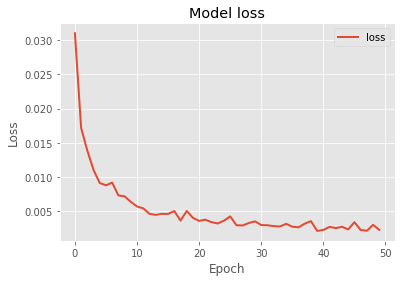

In [177]:
plt.plot(history['loss'], linewidth=2, label='loss')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [178]:
pred = autoencoder.predict(suspected_data_scaled)

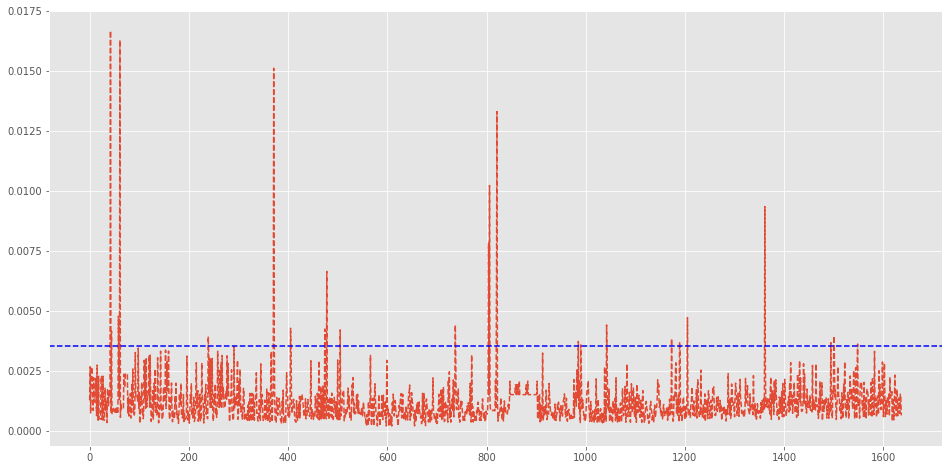

(26,)

In [180]:
mse = np.mean(np.power(suspected_data_scaled - pred, 2), axis=1)
plt.figure(figsize = (16,8))
plt.plot(mse, '--')
y = 3*np.mean(mse)
plt.axhline(y=y, color='b', linestyle='--',label='threshold')
plt.show()
out = np.where(mse > y)
out[0].shape

In [181]:
out

(array([  42,   44,   58,   61,  239,  371,  372,  405,  474,  478,  505,
         737,  804,  806,  820,  821,  985,  990, 1042, 1173, 1189, 1205,
        1361, 1494, 1500, 1548]),)

In [182]:
df.iloc[out]

,Unnamed: 0,LineId,host,timestamp,service,thread_id,message_id,structured_data,log_level,log_message,EventId,EventTemplate,ParameterList,new_time
42,42,43,NaN,35:18.3,1,1,1,1,1,43,6,loading xml bean definition from url,3,00:35:18
44,44,45,NaN,35:18.3,1,1,1,1,1,45,6,loading xml bean definition from url,3,00:35:18
58,58,59,NaN,35:18.4,1,1,1,1,1,59,7,overriding bean definition for bean with diffe...,2,00:35:18
61,61,62,NaN,35:18.5,1,1,1,1,1,62,6,loading xml bean definition from url,3,00:35:18
239,239,240,NaN,36:16.3,1,1,4,1,1,224,55,tunnel ip endpoint host localhost key access i...,3,00:36:16
371,371,372,NaN,37:45.3,1,1,2,1,1,338,87,stream caching is not in use if using stream t...,74,00:37:45
372,372,373,NaN,37:45.3,1,1,2,1,1,339,88,endpoint seda event concurrent consumer multip...,8,00:37:45
405,405,406,NaN,37:51.0,1,1,9,1,1,368,97,added bean to the map from the init,3,00:37:51
474,474,475,NaN,37:54.9,1,1,2,1,1,437,102,initializing bb fa md push client,83,00:37:54
478,478,479,NaN,37:55.0,1,1,2,1,1,441,103,bb fa for black berry,85,00:37:55


#### Class column contains the information as
- 1 is its anomalous
- 0 if its not

In [183]:
final = np.zeros(df.shape[0])
final.shape
final[out] = 1

df = pd.read_csv("CleanedLog.csv")
df['Class'] = final
df

,Unnamed: 0,LineId,host,timestamp,service,thread_id,message_id,structured_data,log_level,log_message,EventId,EventTemplate,ParameterList,Class
0,0,1,NaN,35:16.1,CORE,{main},-|-,[{}],INFO,Found Public API candidate:C:/Program Files/De...,61c07f7d,found public api,<bound method Parser.get_parameter_list of <dr...,0.0
1,1,2,NaN,35:16.2,CORE,{main},-|-,[{}],INFO,Public API to load:C:\Program Files\DellCamero...,3a100ee9,public api,<bound method Parser.get_parameter_list of <dr...,0.0
2,2,3,NaN,35:16.2,CORE,{main},-|-,[{}],INFO,Root WebApplicationContext: initialization sta...,1ad8b3a2,root web application context initialization st...,<bound method Parser.get_parameter_list of <dr...,0.0
3,3,4,NaN,35:16.4,CORE,{main},-|-,[{}],INFO,Refreshing Root WebApplicationContext: startup...,28410e9c,refreshing root web application context startu...,<bound method Parser.get_parameter_list of <dr...,0.0
4,4,5,NaN,35:16.5,CORE,{main},-|-,[{}],INFO,Loading XML bean definitions from ServletConte...,a27de3e5,loading xml bean definition from servlet conte...,<bound method Parser.get_parameter_list of <dr...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102461,102461,102462,NaN,39:31.4,CORE,{wff-thread-116},none|none,"[{{Correlation-Id,d93c5a57-f236-4dbf-8139-c0e3...",INFO,[filterPolicySettingsByUserDevice] Called poli...,df7da411,filter policy setting by user device called po...,<bound method Parser.get_parameter_list of <dr...,0.0
102462,102462,102463,NaN,39:31.4,CORE,{wff-thread-116},none|core,"[{{Correlation-Id,d93c5a57-f236-4dbf-8139-c0e3...",INFO,getKeyInfo OK for endpointUUID: 1A630808-E811-...,773e2657,get key info ok for endpoint uuid,<bound method Parser.get_parameter_list of <dr...,0.0
102463,102463,102464,NaN,39:31.4,CORE,{wff-thread-116},none|none,"[{{Correlation-Id,d93c5a57-f236-4dbf-8139-c0e3...",INFO,Time to complete request in milliseconds: 28,d8df4591,time to complete request in millisecond,<bound method Parser.get_parameter_list of <dr...,0.0
102464,102464,102465,NaN,39:31.4,CORE,{gif-notify,thread-18},"none|none [{{Correlation-Id,d93c5a57-f236-4dbf...",INFO,returning HTTP response code 200,509a5b6e,returning http response code,<bound method Parser.get_parameter_list of <dr...,0.0


### Export final csv file 

In [184]:
file_name = "final_CleanedLog.csv"
df.to_csv(file_name)